In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import torchvision.transforms as T
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

from torchdiffeq import odeint

from neuralop.models import FNO2d, FNO

from ndo_utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
cnn = SimpleConvNet().to(device=device)
cnn.load_state_dict(torch.load('./data/inverse_heat_cnn.pth'))

<All keys matched successfully>

In [3]:
fno = FNO2d(
    in_channels=1,
    out_channels=1,
    n_modes_width=16,
    n_modes_height=16,
    hidden_channels=32,
).to(device=device)

fno.load_state_dict(torch.load('./data/inverse_heat_fno.pth', weights_only=False))
fno.eval()

FNO2d(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 1, kernel_size

In [4]:
ndo = InverseHeatNDO(modes=(16,16), hidden_channels=32, atol=1e-5, rtol=1e-5).to(device=device)

state_dict = torch.load('./data/inverse_heat_ndo.pth', weights_only=False)

if '_metadata' in state_dict:
    del state_dict['_metadata']

ndo.load_state_dict(state_dict)
ndo.eval()

InverseHeatNDO(
  (fno): FNO2d(
    (positional_embedding): GridEmbeddingND()
    (fno_blocks): FNOBlocks(
      (convs): ModuleList(
        (0-3): 4 x SpectralConv(
          (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
        )
      )
      (fno_skips): ModuleList(
        (0-3): 4 x Flattened1dConv(
          (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
      )
      (channel_mlp): ModuleList(
        (0-3): 4 x ChannelMLP(
          (fcs): ModuleList(
            (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
            (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
          )
        )
      )
      (channel_mlp_skips): ModuleList(
        (0-3): 4 x SoftGating()
      )
    )
    (lifting): ChannelMLP(
      (fcs): ModuleList(
        (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
        (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
      )
    )
    (projection): ChannelMLP(
      (fcs): ModuleList(
    

In [5]:
data_test = torch.load('./data/heat_dataset_test.pt')
u0_test = data_test['u0']
ut_trajectory_test = data_test['ut_trajectory']
ut_final_test = data_test['ut_final']


u0_test = u0_test.unsqueeze(1).to(device)
ut_trajectory_test = ut_trajectory_test.unsqueeze(1).to(device)
ut_final_test = ut_final_test.unsqueeze(1).to(device)

In [6]:
s_span = torch.tensor(np.linspace(0,4,201), device=device)

In [7]:
with torch.no_grad():

    NDO_trajectory = ndo(ut_final_test[0, ...].unsqueeze(0), s_span=s_span).detach().cpu().squeeze([1,2]).numpy()

    FNO_trajectory = [ut_final_test[0, ...].unsqueeze(0)]

    for ii in range(1, len(s_span)):
        FNO_trajectory.append(fno(FNO_trajectory[-1]))

    FNO_trajectory = torch.stack(FNO_trajectory, dim=0).detach().cpu().squeeze([1,2]).numpy()

    CNN_trajectory = [ut_final_test[0, ...].unsqueeze(0)]

    for ii in range(1, len(s_span)):
        CNN_trajectory.append(cnn(CNN_trajectory[-1]))
        
    CNN_trajectory = torch.stack(CNN_trajectory, dim=0).detach().cpu().squeeze([1,2]).numpy()

In [8]:
true_solution = u0_test[0, ...].detach().cpu().squeeze([1,2]).numpy()

err_cnn = np.max(np.abs(CNN_trajectory - true_solution), axis=(1,2))
err_fno = np.max(np.abs(FNO_trajectory - true_solution), axis=(1,2))
err_ndo = np.max(np.abs(NDO_trajectory - true_solution), axis=(1,2))

In [9]:
tspan = np.linspace(0, 200, 201)
n_frames = 201
import matplotlib.animation as animation

plt.style.use('dark_background')

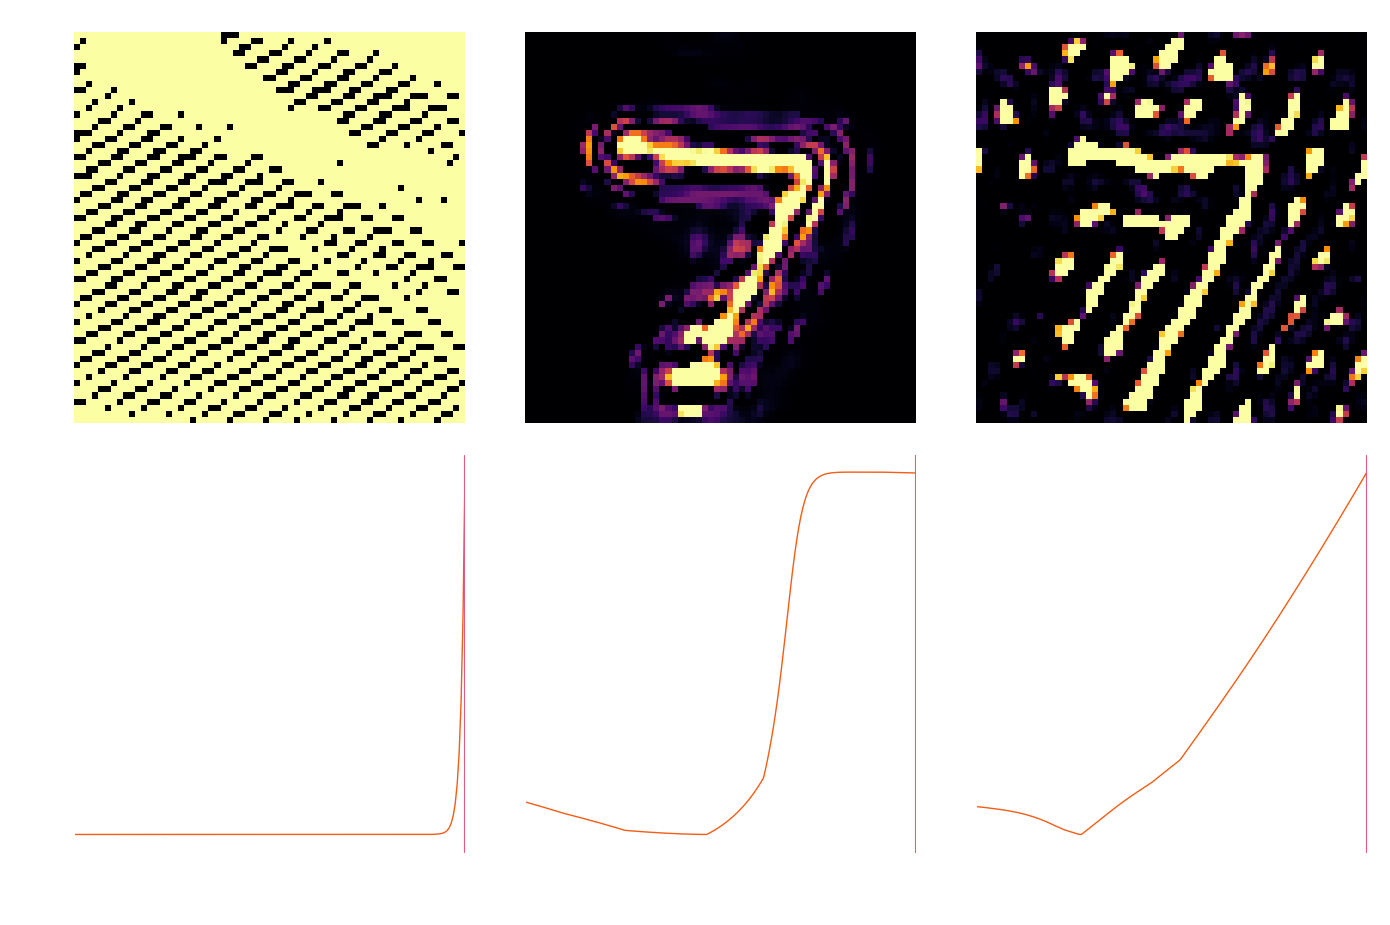

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(14, 9.3))
ax_img_cnn, ax_img_fno, ax_img_ndo = axes[0]
ax_err_cnn, ax_err_fno, ax_err_ndo = axes[1]

fig.set_facecolor('none')

for ax in axes[0]:
    ax.set_facecolor('none')
for ax in axes[1]:
    ax.set_facecolor('none')


ax_img_cnn.set_title("CNN")
ax_img_fno.set_title("FNO")
ax_img_ndo.set_title("NDO")


im_cnn = ax_img_cnn.imshow(CNN_trajectory[0], cmap='inferno', vmin=0, vmax=1, animated=True)
im_fno = ax_img_fno.imshow(FNO_trajectory[0], cmap='inferno', vmin=0, vmax=1, animated=True)
im_ndo = ax_img_ndo.imshow(NDO_trajectory[0], cmap='inferno', vmin=0, vmax=1, animated=True)

for ax in (ax_img_cnn, ax_img_fno, ax_img_ndo):
    ax.axis('off')


line_cnn, = ax_err_cnn.plot(tspan, err_cnn, lw=1, color='#f25e16', animated=True)
line_fno, = ax_err_fno.plot(tspan, err_fno, lw=1, color='#f25e16', animated=True)
line_ndo, = ax_err_ndo.plot(tspan, err_ndo, lw=1, color='#f25e16', animated=True)


vline_cnn = ax_err_cnn.axvline(0, color='#e94f74', animated=True)
vline_fno = ax_err_fno.axvline(0, color='#e94f74', animated=True)
vline_ndo = ax_err_ndo.axvline(0, color='#e94f74', animated=True)


ax_err_cnn.set_ylabel("$\\sup(|u - u_{0,true}|)$")
for ax in (ax_err_cnn, ax_err_fno, ax_err_ndo):
    ax.set_xlim(0, tspan[-1])


fig.supxlabel("time")

plt.tight_layout()

def update(frame):
    im_cnn.set_data(CNN_trajectory[frame])
    im_fno.set_data(FNO_trajectory[frame])
    im_ndo.set_data(NDO_trajectory[frame])

    xpos = tspan[frame]

    vline_cnn.set_xdata([xpos, xpos])
    vline_fno.set_xdata([xpos, xpos])
    vline_ndo.set_xdata([xpos, xpos])
    return (im_cnn, im_fno, im_ndo, vline_cnn, vline_fno, vline_ndo)

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=60, blit=True)

ani.save('./im/backward_limit.png', writer=animation.PillowWriter(fps=15))